# Billboard Top 100 song predictions
### Making predictions on song data from a sample of the Million Song Dataset 
* http://millionsongdataset.com/pages/getting-dataset/#subset
* Lyrics from genius.com were brought in as another datapoint

In [ ]:
import sys
#need this to get correct packages imported
# sys.path.append("/Users/scottmagnuson/anaconda3/lib/python3.6/site-packages")
import pandas as pd
import numpy as np
import os, copy, nltk, string #gensim
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.dummy import DummyClassifier
import seaborn as sns
from matplotlib import pyplot
from xgboost.sklearn import XGBClassifier

In [20]:
#Bringing in all of the datasets that were pulled from another notebooks
path = os.getcwd()
music = pd.read_csv(path+'/music.csv')
lyrics = pd.read_csv(path+'/lyrics.csv')
billboard = pd.read_csv(path+'/billboard.csv')

# merge all of the datasets 
music = music[music["year"]>1970]
all_songs = pd.merge(left=music, right=lyrics, left_on=['artist.name','title'], right_on=['0','1'])

del billboard['Unnamed: 0']
billboard_songs = pd.merge(left=all_songs, right=billboard, left_on='title', right_on='title')
billboard_songs = billboard_songs.drop_duplicates()
print('total songs in dataset: ' + str(len(all_songs)))
print("songs on billboard: " + str(len(billboard_songs)))

print('percent of songs that made billboard: ' + str(len(billboard_songs)/len(all_songs)))

#More manipulation
all_songs = all_songs.rename(index=str, columns={ "2": "lyrics", "Unnamed: 0" : "word_count"})
all_songs = all_songs.assign(billboard=all_songs.title.isin(billboard.title).astype(int))
all_songs = all_songs.drop(['0', '1'], axis=1)
all_songs = all_songs.reset_index(drop=True)

display(all_songs.head(5))
display(all_songs.columns)


total songs in dataset: 3527
songs on billboard: 1163
percent of songs that made billboard: 0.3297419903600794


,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year,word_count,lyrics,billboard
0,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982,249,Adam Ant/Marco Pirroni\nEvery girl is a someth...,0
1,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007,3010,"I've just erased it's been a while, I've got a...",0
2,0.332276,AR8ZCNI1187B9A069B,Planet P Project,NaN,0.0,0.806,1.91886,0.440,1.22595,269.81832,...,86.643,new wave,0.959766,4.0,0.487,Pink World,1984,335,"There's a pink world\nComin' down\nYeah, there...",0
3,0.553072,ARIK43K1187B9AE54C,Lionel Richie,soul and reggae,1.0,0.191,0.82842,1.000,0.82842,307.38240,...,125.197,quiet storm,1.000000,3.0,0.211,Tonight Will Be Alright,1986,413,[Verse 1]\nLittle darling\nWhere you've been s...,0
4,0.447935,ARD842G1187B997376,Blue Rodeo,canadian,2.0,0.507,1.32118,0.000,0.30065,491.12771,...,119.826,country rock,1.000000,4.0,0.756,Floating,1987,448,"Lead Vocal by Greg\n\nWell, these late night c...",0


Index(['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
       'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year', 'word_count', 'lyrics', 'billboard'],
      dtype='object')

In [40]:
#get rid of tags that have missing values and add target for train test split
train = copy.deepcopy(all_songs)
target = copy.deepcopy(all_songs.billboard)

In [41]:
stopWords = nltk.corpus.stopwords.words()
punctuation = list(string.punctuation + " ") 
translateTable = str.maketrans('','',string.punctuation)
blacklist = [" ", "", "[","]","verse","chorus","x2","x3","x4","x5"] + stopWords

# Preprocessor that we wound up not using. We found better results with just using stopwords.
# Wordvectorizer was much faster at getting rid of stop words so just used that
def preprocess(text, stopWords=[], wordStem=False, punctuation=True, lemmatize=False, includeNumbers=True):
    sentences = nltk.sent_tokenize(text)
    processedText = ''
    for sentence in sentences:
#       Get rid of weird punctuation
        if (punctuation):
            sentence = sentence.translate(translateTable)
        words = nltk.word_tokenize(sentence)
        processedSentence = []
        for word in words:
            
#           Getting rid of stopwords here
            if word not in(stopWords) and word is not "" :
                word = word.lower()
    #           Handles if we want to stemm
                if (wordStem):
                   word = stemmer.stem(word)
    #           Handles if we want to lemmatize
                if (lemmatize):
                   word = WordNetLemmatizer().lemmatize(wordStem,'v')
                
                #handle if we want to include numbers
                if (includeNumbers):
                    processedSentence.append(word)
                else:
                    if (word is not word.isnumeric()):
                        processedSentence.append(word)
        processedString = ' '.join(processedSentence)
        
        if(punctuation):
            processedString = processedString + '.'
        processedText = processedText + " " + processedString
    return processedText


#Did not use see func def
# train.lyrics = train.lyrics.map(lambda x: preprocess(x, lacklist))
# train.to_csv("train_data.csv")
train = train.drop('billboard', axis=1)

In [42]:
# train=pd.read_csv('music.csv')
display(train.columns)

#Split the data on a random state of 0
x_train, x_test, y_train, y_test = train_test_split(train,
                                                                        target,
                                                                        test_size=.5,
                                                                        train_size=.4,
                                                                        random_state=0,
                                                                        stratify = target)

# Found the TFIDF vectorizer to perform marginally better
vect = TfidfVectorizer(stop_words=blacklist, ngram_range=(1,2),min_df=4, binary=True).fit(x_train['lyrics']) #85.6
# vect=CountVectorizer(stop_words=blacklist, ngram_range=(1,2),min_df=4, binary=True).fit(x_train_text) #85.1
x_train_text_trans= vect.transform(x_train['lyrics'])
x_test_text_trans = vect.transform(x_test['lyrics'])

#Creating the XGBoost classifier for lyric data - this was found to hold the best accuracy
XGB_model = XGBClassifier()
XGB_model.fit(x_train_text_trans, y_train)

XGB_pred = XGB_model.predict(x_test_text_trans)

XGB_accuracy = XGB_model.score(x_test_text_trans, y_test)
print("Accuracy: %.2f%%" % (XGB_accuracy * 100.0)) #85.75

Index(['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
       'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year', 'word_count', 'lyrics'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 85.60%


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
#Adding on prediction of lyrics to billboard top 100 on Train
display(train.lyrics.values[0])
firstLyricPredict = XGB_model.predict_proba(vect.transform([train.lyrics.values[0]]))
display(firstLyricPredict[0][0])

#Predicticing the probability of each song's lyrics to reach billboard top 100 
def xgb_predict_probability(x):
    prediction = XGB_model.predict_proba(vect.transform([x]))
    return prediction[0][0]
train['lyric_predict'] = train.lyrics.map(lambda x: xgb_predict_probability(x))


"Adam Ant/Marco Pirroni\nEvery girl is a something girl\nEvery girl is a something girl\nEvery girl is a something girl\nShe's got something\nShe's got something\n\nEvery girl is a something girl\nEvery girl has a somehing smile\nEvery girl is a something girl\nFor a while\nFor a while\n\nIf I had three wishes I know mine\nI would not ask the stars to shine\nI wouldn't ask for gems or pearls\nI'd ask for the something girls\n\nEvery girl is a something girl\nFrom the whites of her eyes\nTo the tip of a curl\nEvery girl sends a something boy\nWith that something\nWith that something\n\nWhen this old world won't treat you right\nYou're not feeling yourself tonight\nThink of someone you can do\nRelax and let that something through\nEvery girl is a something girl\nEvery girl is a something girl\nEvery girl is a something girl\nShe's got she's got something\nShe's got she's got something\nEvery girl is a something girl\nShe's got, she's got something\nEvery girl is a something girl\nShe's g

0.79696

In [44]:
# Adding sentiment analysis to the Train dataframe
display(train.head())
nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()

sentiments = []
for lyrics in train['lyrics']:
    score = sentiment.polarity_scores(lyrics)['compound']
    sentiments.append(score)

# add column to database
train['sentiment'] = sentiments

#Dropping features that either have lots of missing values or are a pre-predictor to success
drop_attr = ['lyrics', 'familiarity', 'release.id', 'artist.hotttnesss', 'artist.id', 'artist.name', 'similar', 'terms', 'artist_mbtags', 'artist_mbtags_count', 'latitude', 'location', 'longitude', 'release.name','artist.name', 'song.id', 'title' ,'song.hotttnesss']
train = train.drop(drop_attr, axis=1)
# For safe keeping of data
music.to_csv("final.csv")


,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year,word_count,lyrics,lyric_predict
0,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982,249,Adam Ant/Marco Pirroni\nEvery girl is a someth...,0.796960
1,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007,3010,"I've just erased it's been a while, I've got a...",0.920395
2,0.332276,AR8ZCNI1187B9A069B,Planet P Project,NaN,0.0,0.806,1.91886,0.440,1.22595,269.81832,...,86.643,new wave,0.959766,4.0,0.487,Pink World,1984,335,"There's a pink world\nComin' down\nYeah, there...",0.761479
3,0.553072,ARIK43K1187B9AE54C,Lionel Richie,soul and reggae,1.0,0.191,0.82842,1.000,0.82842,307.38240,...,125.197,quiet storm,1.000000,3.0,0.211,Tonight Will Be Alright,1986,413,[Verse 1]\nLittle darling\nWhere you've been s...,0.808695
4,0.447935,ARD842G1187B997376,Blue Rodeo,canadian,2.0,0.507,1.32118,0.000,0.30065,491.12771,...,119.826,country rock,1.000000,4.0,0.756,Floating,1987,448,"Lead Vocal by Greg\n\nWell, these late night c...",0.898278


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/scottmagnuson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [51]:
#Need to drop lyric data as we are no longer using that and train/test split with same randomState
x_test = x_test.drop('lyrics', axis=1)
x_train = x_train.drop('lyrics', axis=1)
# train = train.drop('lyric_predict', axis=1)


#Here we use the same random_state to get the exact same data split but with added engineered features
x_train, x_test, y_train, y_test = train_test_split(train,
                                                                        target,
                                                                        test_size=.4,
                                                                        train_size=.5,
                                                                        random_state=0,
                                                                        stratify = target)



In [52]:
#for testing model and performance
def testingModel(model, X_train, Y_train, text):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring = "roc_auc")
    print(text)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

def performanceModel(model ,X_test, Y_test ):
    prediction = model.predict(X_test)
    accuracy = model.score(X_test, Y_test)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('F1 score:',f1_score(Y_test,prediction))
    print('Precision score', precision_score(Y_test, prediction))
    print('Recall score', recall_score(Y_test, prediction))

In [53]:
#creating a basic XGB Classifier
display(x_train.columns)
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)

XGB_test = testingModel(XGB_model, x_train, y_train, 'XGB Classifier')
performanceModel(XGB_model, x_test,y_test)


Index(['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
       'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
       'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
       'tatums_start', 'tempo', 'terms_freq', 'time_signature',
       'time_signature_confidence', 'year', 'word_count', 'lyric_predict',
       'sentiment'],
      dtype='object')

XGB Classifier
Scores: [0.90123457 0.93209877 0.83382716 0.94493827 0.88197531 0.93589744
 0.86410256 0.86512821 0.84563758 0.91068663]
Mean: 0.891552649190233
Standard Deviation: 0.0372883764606849
Accuracy: 82.78%
F1 score: 0.2568807339449542
Precision score 0.3652173913043478
Recall score 0.19811320754716982


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
#We want to make the model more conservative as we don't care about recall as much and attempting to fight overfitting
parameters = {#'tree_method':  ['gpu_hist', 'gpu_exact'], #probably want to use exact here for small dataset
              'eta': [0.2, .3, .4], #.3 is default. We have a more less conservative (.2) and more conservative(.5)
              'max_depth': [2,3,6], #6 is default possible overfitting?
              'min_child_weight': [.5, 1, 5, ], #defaults to 1
              'gamma': [0, 0.5, 1], #defaults to 0
              'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)],
              'verbosity': [0],
             }

XGB_tuned = GridSearchCV(XGB_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
XGB_tuned.fit(x_train, y_train)
XGB_test = testingModel(XGB_tuned, x_train, y_train, 'XGB Classifier')
performanceModel(XGB_tuned, x_test,y_test)

XGB Classifier
Scores: [0.90469136 0.95135802 0.80814815 0.95382716 0.89234568 0.93897436
 0.89487179 0.84897436 0.84099122 0.92746515]
Mean: 0.896164725902981
Standard Deviation: 0.04721288200138039
Accuracy: 67.01%
F1 score: 0.2682926829268293
Precision score 0.3793103448275862
Recall score 0.20754716981132076


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
#Logistic Regression Model
LR_model=LogisticRegression(C=.001)
LR_model.fit(x_train,y_train)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
LR_model= GridSearchCV(LR_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
LR_model.fit(x_train,y_train)
LR_test = testingModel(LR_model, x_train, y_train, 'Logistic Regression Model')
performanceModel(LR_model, x_test,y_test)

Logistic Regression Model
Scores: [0.90839506 0.94296296 0.83160494 0.95432099 0.90864198 0.91205128
 0.90717949 0.86564103 0.8200826  0.91946309]
Mean: 0.897034341000784
Standard Deviation: 0.0420411698808017
Accuracy: 68.93%
F1 score: 0.23452768729641693
Precision score 0.37894736842105264
Recall score 0.16981132075471697


In [56]:
#Decision Tree Clasifier
DTC_model = tree.DecisionTreeClassifier()
DTC_model.fit(x_train, y_train)
parameters= {'max_depth': np.arange(3, 20)}
DTC_model= GridSearchCV(DTC_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
DTC_model.fit(x_train,y_train)
DTC_test = testingModel(DTC_model, x_train, y_train, 'Decision Tree Clasifier')
performanceModel(DTC_model, x_test,y_test)

Decision Tree Clasifier
Scores: [0.84518519 0.84703704 0.81555556 0.95296296 0.80703704 0.87769231
 0.87064103 0.82179487 0.80420754 0.92359319]
Mean: 0.8565706705673148
Standard Deviation: 0.047681425958513726
Accuracy: 63.05%
F1 score: 0.26865671641791045
Precision score 0.36585365853658536
Recall score 0.21226415094339623


In [57]:
#K Neighbors Classifier

KNN_model = KNeighborsClassifier()
KNN_model.fit(x_train, y_train)
parameters= {'n_neighbors': np.arange(8, 25),
            'weights' : ['uniform', 'distance'],
            }
KNN_model= GridSearchCV(KNN_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
KNN_model.fit(x_train,y_train)
KNN_test = testingModel(KNN_model, x_train, y_train, 'K Neighbors Classifier')
performanceModel(KNN_model, x_test,y_test)

K Neighbors Classifier
Scores: [0.48987654 0.51493827 0.5617284  0.5562963  0.53802469 0.60025641
 0.6224359  0.50435897 0.67191533 0.63964894]
Mean: 0.5699479754233668
Standard Deviation: 0.05825941522551044
Accuracy: 49.45%
F1 score: 0.0
Precision score 0.0
Recall score 0.0


In [58]:
#Random Forest Classifier
RFC_model = RandomForestClassifier()
parameters = { 'n_estimators': [10, 50, 100, 200, 400],
               'max_features': ['auto', 'sqrt', 'log2']}

RFC_model = GridSearchCV(RFC_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
RFC_model.fit(x_train,y_train)
RFC_test = testingModel(RFC_model, x_train, y_train, 'Random Forest Classifier')
performanceModel(RFC_model, x_test,y_test)

Random Forest Classifier
Scores: [0.84567901 0.89358025 0.81987654 0.94617284 0.83518519 0.8725641
 0.86884615 0.85025641 0.8515746  0.94501807]
Mean: 0.872875316290305
Standard Deviation: 0.04117829424358092
Accuracy: 66.29%
F1 score: 0.2621951219512195
Precision score 0.3706896551724138
Recall score 0.2028301886792453


In [59]:
#Dummy Classifier
dummy=DummyClassifier(strategy='stratified')
dummy.fit(x_train, y_train)
dummy_test = testingModel(dummy, x_train, y_train, 'Dummy model')
performanceModel(dummy, x_test,y_test)

Dummy model
Scores: [0.48222222 0.47740741 0.52592593 0.53925926 0.52111111 0.46769231
 0.46512821 0.49692308 0.52813629 0.55743418]
Mean: 0.5061239985468173
Standard Deviation: 0.03077368238558932
Accuracy: 74.84%
F1 score: 0.1927710843373494
Precision score 0.19704433497536947
Recall score 0.18867924528301888


/anaconda3/lib/python3.6/site-packages/sklearn/dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


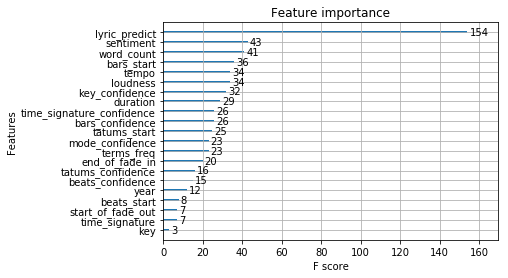

In [61]:
# plot feature importance
xgb.plot_importance(XGB_model)
pyplot.show()


In [84]:

results = pd.DataFrame([{'Model': 'Logistic Regression', 'Score': LR_test},
                        {'Model': 'XGBoost', 'Score': XGB_test},         
                        {'Model': 'Random Forest', 'Score': RFC_test}, 
                        {'Model': 'Decission Tree', 'Score': DTC_test}, 
                        {'Model': 'KNN', 'Score': KNN_test}, 
                       ])

display(results.set_index('Score'))


,Model
Score,
0.897034,Logistic Regression
0.896165,XGBoost
0.872875,Random Forest
0.856571,Decission Tree
0.569948,KNN


In [87]:
# One more without lyric prediction
# x_train = x_train.drop('lyric_predict',axis=1)
# x_test = x_test.drop('lyric_predict', axis=1)
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)
parameters = {#'tree_method':  ['gpu_hist', 'gpu_exact'], #probably want to use exact here for small dataset
              'eta': [0.2, .3, .4], #.3 is default. We have a more less conservative (.2) and more conservative(.5)
              'max_depth': [2,3,6], #6 is default possible overfitting?
              'min_child_weight': [.5, 1, 5, ], #defaults to 1
              'gamma': [0, 0.5, 1], #defaults to 0
              'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)],
              'verbosity': [0],
             }

XGB_tuned_lyrics = GridSearchCV(XGB_model, parameters, cv=5, scoring='roc_auc',n_jobs=-1)
XGB_tuned_lyrics.fit(x_train, y_train)
XGB_test_lyrics = testingModel(XGB_tuned_lyrics, x_train, y_train, 'XGB Classifier')
performanceModel(XGB_tuned_lyrics, x_test,y_test)

XGB Classifier
Scores: [0.60345679 0.71580247 0.65555556 0.70987654 0.53234568 0.53923077
 0.67538462 0.65307692 0.710635   0.62364481]
Mean: 0.6419009158874931
Standard Deviation: 0.06371322916106052
Accuracy: 61.53%
F1 score: 0.06278026905829595
Precision score 0.6363636363636364
Recall score 0.0330188679245283


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
